# Analyse einer PV-Anlage

Dieses Notebook analysiert die Produktions- und Verbrauchsdaten einer Photovoltaik-Anlage. Es werden folgende Aspekte untersucht:

- Tägliche Energieproduktion und Verbrauch
- Durchschnittlicher Tagesverlauf
- Analyse der Eigenversorgung und Energiebilanz

## Daten importieren und vorbereiten

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing


### Daten einlesen
Wir lesen die Daten aus drei CSV-Dateien (A.csv, B.csv, C.csv) und führen sie zusammen.

In [ ]:
# Daten einlesen
df_a = pd.read_csv('data/A.csv', parse_dates=['Timestamp'])
df_b = pd.read_csv('data/B.csv', parse_dates=['Timestamp'])
df_c = pd.read_csv('data/C.csv', parse_dates=['Timestamp'])

# Daten zusammenführen
dfs = [df_a, df_b, df_c]
df = pd.concat(dfs, axis=0)
df = df.sort_values('Timestamp').reset_index(drop=True)

# Zeige die ersten Zeilen des zusammengeführten Datensatzes
df.head()


,Timestamp,Generation_kW,Grid_Feed-In_kW,Grid_Supply_kW,Overall_Consumption_Calc_kW
0,2019-01-01 00:00:00,0.0,0.0,4.212,4.212
1,2019-01-01 00:00:00,NaN,0.0,2.800,NaN
2,2019-01-01 00:00:00,0.0,0.0,5.400,5.400
3,2019-01-01 00:15:00,0.0,0.0,4.212,4.212
4,2019-01-01 00:15:00,NaN,0.0,2.800,NaN


### Tägliche Summen berechnen
Wir aggregieren die Daten auf Tagesebene, um die täglichen Summen für Produktion und Verbrauch zu analysieren.

In [ ]:
# Tägliche Summen berechnen
df['Date'] = df['Timestamp'].dt.date
daily_sums = df.groupby('Date').agg({
    'Generation_kW': 'sum',
    'Grid_Supply_kW': 'sum',
    'Grid_Feed-In_kW': 'sum',
    'Overall_Consumption_Calc_kW': 'sum'
}).reset_index()

daily_sums.head()


,Date,Generation_kW,Grid_Supply_kW,Grid_Feed-In_kW,Overall_Consumption_Calc_kW
0,2019-01-01,368.560,1278.776,155.312,1088.024
1,2019-01-02,886.412,1059.700,534.504,1109.208
2,2019-01-03,931.004,1502.120,345.040,1804.284
3,2019-01-04,1007.944,1609.452,319.040,1947.356
4,2019-01-05,9.048,1231.536,0.000,1016.184


## Visualisierungen

### 1. Tägliche Energieproduktion vs. Verbrauch

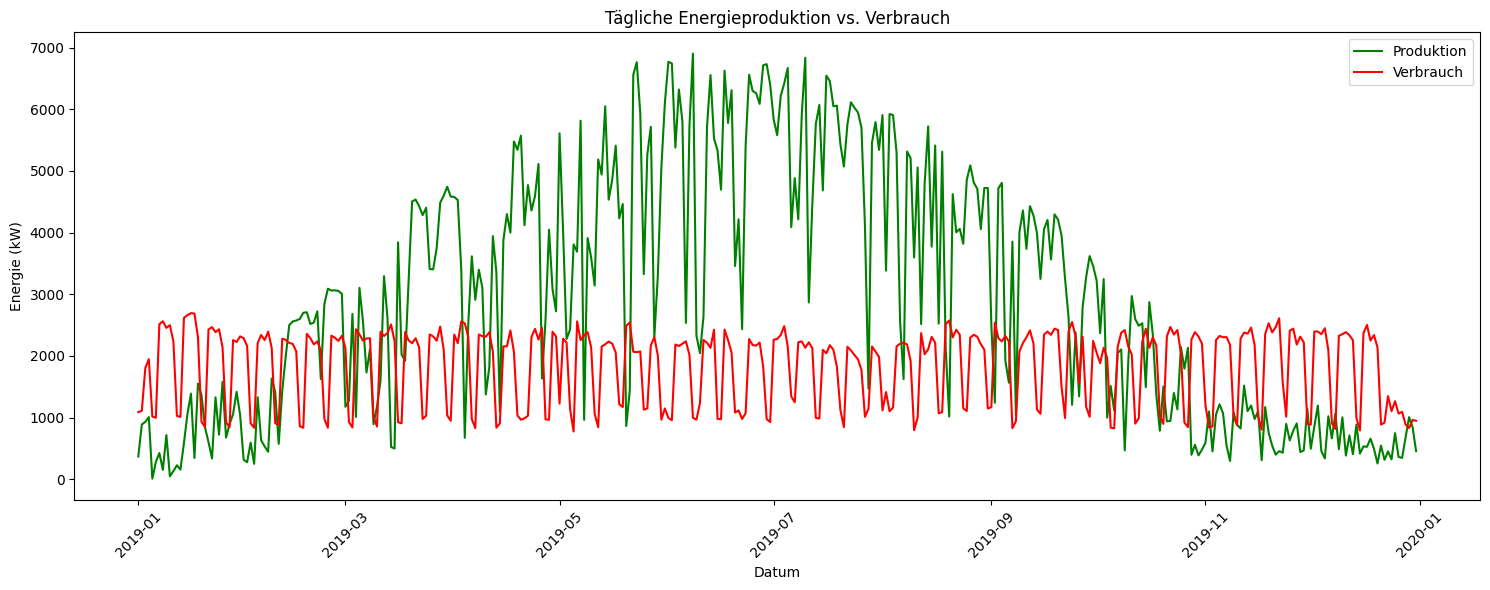

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(daily_sums['Date'], daily_sums['Generation_kW'], label='Produktion', color='green')
plt.plot(daily_sums['Date'], daily_sums['Overall_Consumption_Calc_kW'], label='Verbrauch', color='red')
plt.title('Tägliche Energieproduktion vs. Verbrauch')
plt.xlabel('Datum')
plt.ylabel('Energie (kW)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()


### 2. Durchschnittlicher Tagesverlauf
Dieser Plot zeigt den durchschnittlichen Verlauf von Produktion und Verbrauch über einen Tag.

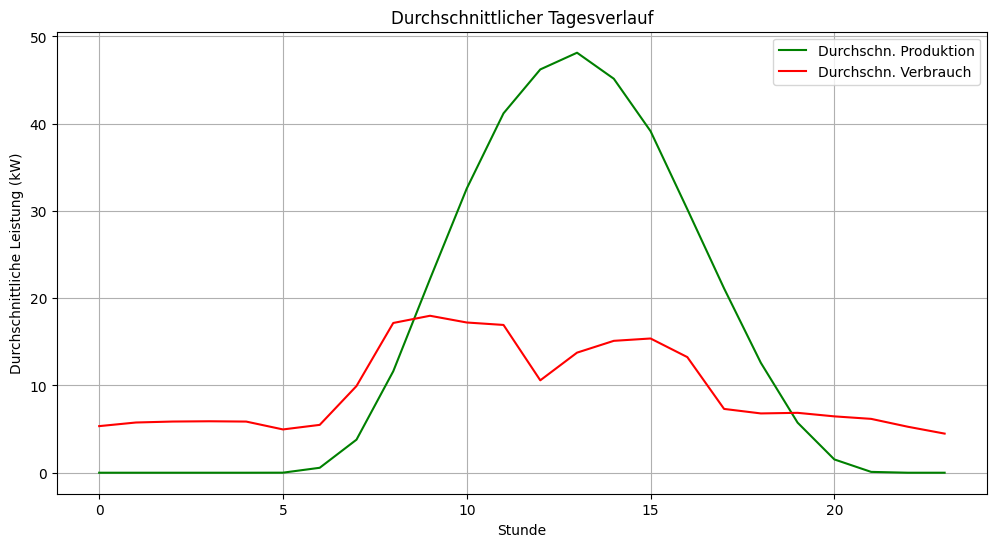

In [ ]:
# Durchschnittlichen Tagesverlauf berechnen
df['Hour'] = df['Timestamp'].dt.hour
hourly_avg = df.groupby('Hour').agg({
    'Generation_kW': 'mean',
    'Overall_Consumption_Calc_kW': 'mean'
}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(hourly_avg['Hour'], hourly_avg['Generation_kW'], label='Durchschn. Produktion', color='green')
plt.plot(hourly_avg['Hour'], hourly_avg['Overall_Consumption_Calc_kW'], label='Durchschn. Verbrauch', color='red')
plt.title('Durchschnittlicher Tagesverlauf')
plt.xlabel('Stunde')
plt.ylabel('Durchschnittliche Leistung (kW)')
plt.legend()
plt.grid(True)


## Analyse der Eigenversorgung
Wir untersuchen, an wie vielen Tagen die Eigenproduktion den Verbrauch decken konnte und berechnen die Gesamtenergiebilanz.

In [ ]:
# Analyse der Eigenversorgung
daily_sums['self_sufficient'] = daily_sums['Generation_kW'] >= daily_sums['Overall_Consumption_Calc_kW']
self_sufficient_days = daily_sums['self_sufficient'].sum()
total_days = len(daily_sums)

print(f"Analyseergebnisse:")
print(f"Gesamtzahl der Tage: {total_days}")
print(f"Tage mit ausreichender Eigenproduktion: {self_sufficient_days}")
print(f"Prozentsatz der Tage mit Eigenversorgung: {(self_sufficient_days/total_days)*100:.2f}%")

# Energiebilanz
total_production = daily_sums['Generation_kW'].sum()
total_consumption = daily_sums['Overall_Consumption_Calc_kW'].sum()
print(f"\nGesamtproduktion: {total_production:.2f} kW")
print(f"Gesamtverbrauch: {total_consumption:.2f} kW")
print(f"Energiebilanz: {((total_production/total_consumption)*100):.2f}% des Verbrauchs wird durch Eigenproduktion gedeckt")


Analyseergebnisse:
Gesamtzahl der Tage: 365
Tage mit ausreichender Eigenproduktion: 229
Prozentsatz der Tage mit Eigenversorgung: 62.74%

Gesamtproduktion: 1056566.47 kW
Gesamtverbrauch: 671094.26 kW
Energiebilanz: 157.44% des Verbrauchs wird durch Eigenproduktion gedeckt


# TSM Plot (Sandra)

c:\PV_Optimization\PV-Optimisation\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\PV_Optimization\PV-Optimisation\.venv\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


=== Modell: Produktion ===
                       ExponentialSmoothing Model Results                       
Dep. Variable:           Production_kWh   No. Observations:                  365
Model:             ExponentialSmoothing   SSE                      451708815.230
Optimized:                         True   AIC                           5128.458
Trend:                         Additive   BIC                           5144.057
Seasonal:                          None   AICC                          5128.692
Seasonal Periods:                  None   Date:                 Fri, 16 May 2025
Box-Cox:                          False   Time:                         14:37:45
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.2385461                alpha                 True
smoothi

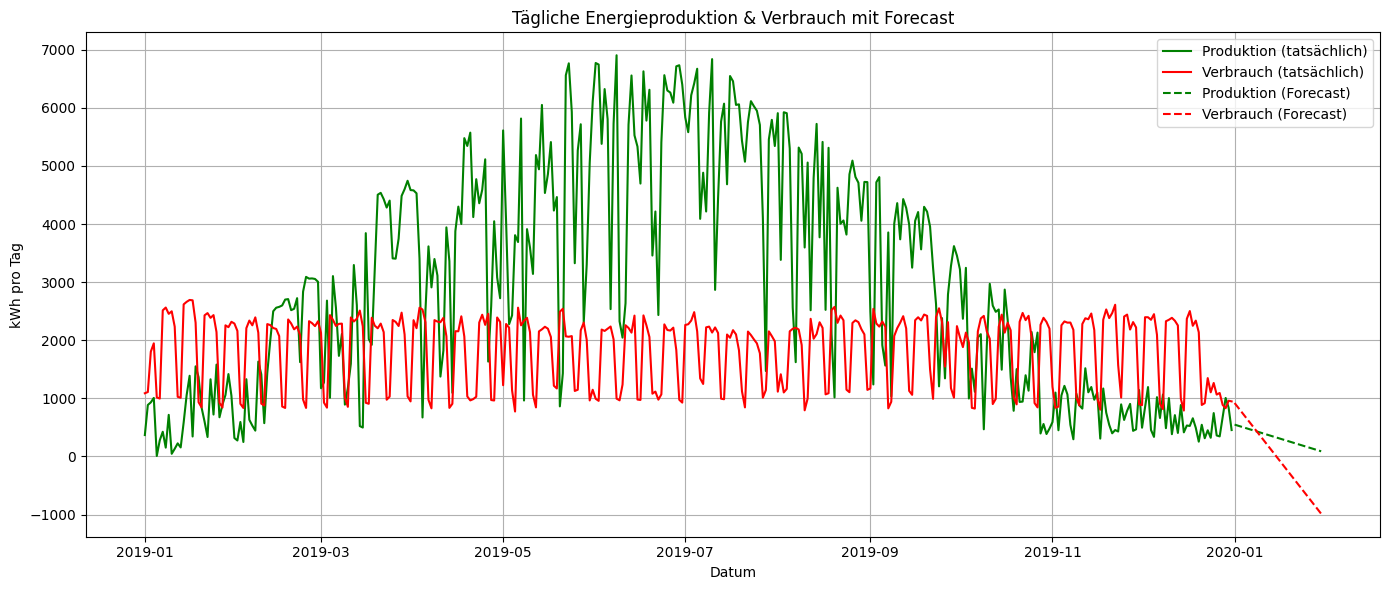

In [ ]:

# Frequenz explizit setzen für saubere Zeitreihe
daily = daily.asfreq('D')

# Holt-Winters Modell: Produktion (ohne Saisonalität)
model_prod = ExponentialSmoothing(
    daily['Production_kWh'],
    trend='add',
    seasonal=None
).fit()

forecast_prod = model_prod.forecast(30)
print("=== Modell: Produktion ===")
print(model_prod.summary())

# Holt-Winters Modell: Verbrauch (ohne Saisonalität)
model_cons = ExponentialSmoothing(
    daily['Consumption_kWh'],
    trend='add',
    seasonal=None
).fit()

forecast_cons = model_cons.forecast(30)
print("\n=== Modell: Verbrauch ===")
print(model_cons.summary())

# Plot: Tatsächlich + Forecast
plt.figure(figsize=(14, 6))
plt.plot(daily['Production_kWh'], color='green', label='Produktion (tatsächlich)')
plt.plot(daily['Consumption_kWh'], color='red', label='Verbrauch (tatsächlich)')
plt.plot(forecast_prod, 'g--', label='Produktion (Forecast)')
plt.plot(forecast_cons, 'r--', label='Verbrauch (Forecast)')
plt.title('Tägliche Energieproduktion & Verbrauch mit Forecast')
plt.xlabel('Datum')
plt.ylabel('kWh pro Tag')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Deckungsgrad

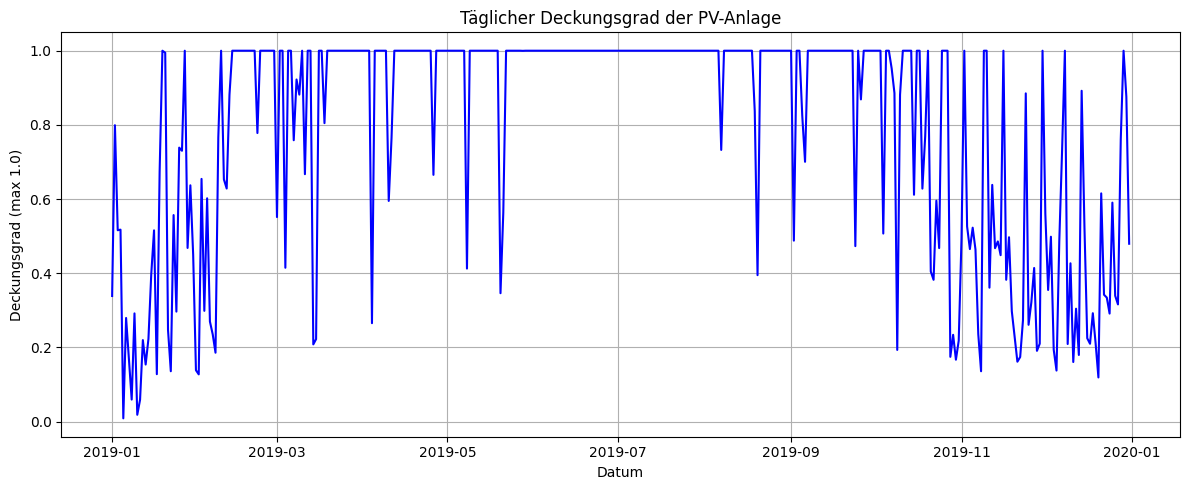

In [ ]:
# Deckungsgrad berechnen
daily['Deckungsgrad'] = daily['Production_kWh'] / daily['Consumption_kWh']

# Deckungsgrad > 1 auf 1 begrenzen (100 % Autarkie)
daily['Deckungsgrad'] = daily['Deckungsgrad'].clip(upper=1)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(daily.index, daily['Deckungsgrad'], color='blue')
plt.title('Täglicher Deckungsgrad der PV-Anlage')
plt.xlabel('Datum')
plt.ylabel('Deckungsgrad (max 1.0)')
plt.grid(True)
plt.tight_layout()
plt.show()


# Verlustleistung messen (Abi)
# Verbrauch auf Tag (Sheena)